In [14]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Scikit-learn modules for preprocessing, modeling, and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

# Load the datasets
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')  # Ensure the test set contains necessary features
sample_submission = pd.read_csv('/content/SampleSubmission.csv')

# Initial data inspection
print("Training Data Head:\n", train_df.head(), "\n")
print("Training Data Info:\n")
train_df.info()
print("\nTraining Data Description:\n", train_df.describe(), "\n")
print("Missing Values in Training Data:\n", train_df.isnull().sum())


Training Data Head:
    sl_no  gender  ssc_p    ssc_b  hsc_p    hsc_b     hsc_s  degree_p  \
0      1       0  67.00   Others  91.00   Others  Commerce     58.00   
1      2       0  79.33  Central  78.33   Others   Science     77.48   
2      3       0  65.00  Central  68.00  Central      Arts     64.00   
3      4       0  56.00  Central  52.00  Central   Science     52.00   
4      5       0  85.80  Central  73.60  Central  Commerce     73.30   

    degree_t workex  etest_p specialisation  mba_p      status    salary  
0   Sci&Tech     No     55.0         Mkt&HR  58.80      Placed  270000.0  
1   Sci&Tech    Yes     86.5        Mkt&Fin  66.28      Placed  200000.0  
2  Comm&Mgmt     No     75.0        Mkt&Fin  57.80      Placed  250000.0  
3   Sci&Tech     No     66.0         Mkt&HR  59.43  Not Placed       NaN  
4  Comm&Mgmt     No     96.8        Mkt&Fin  55.50      Placed  425000.0   

Training Data Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
D

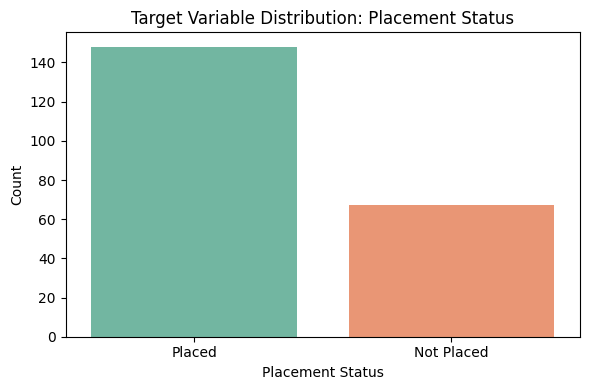

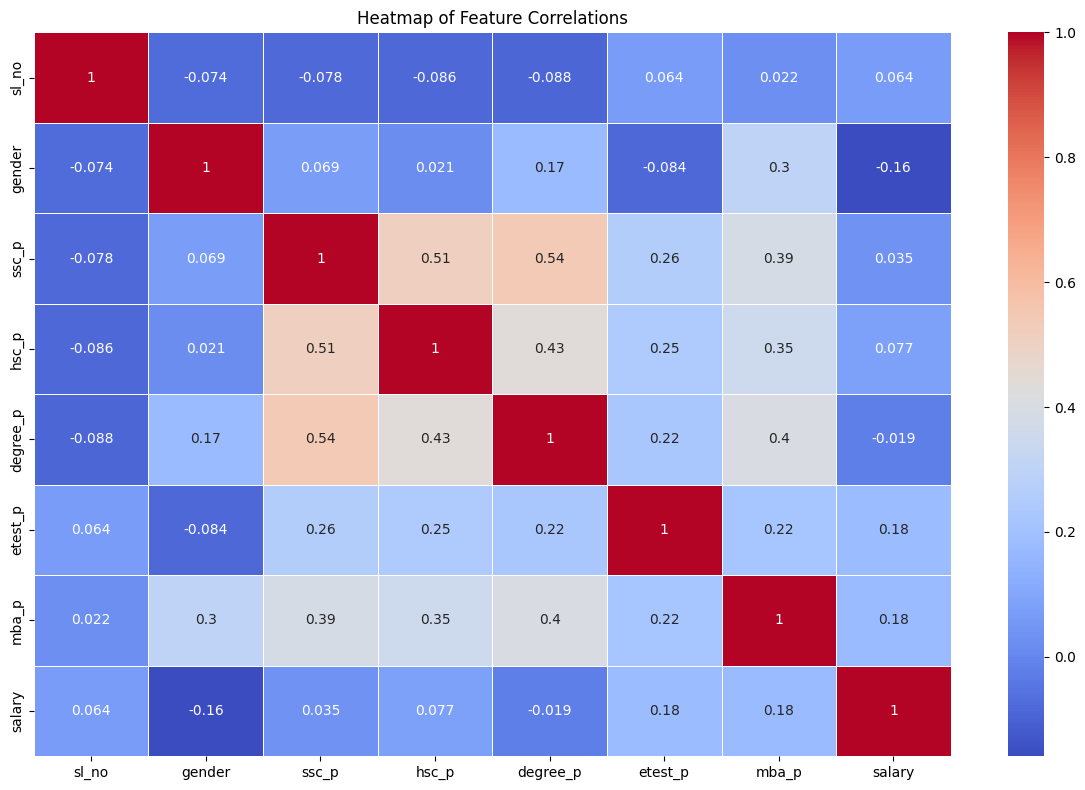


Unique values for categorical columns:

ssc_b: ['Others' 'Central']

hsc_b: ['Others' 'Central']

hsc_s: ['Commerce' 'Science' 'Arts']

degree_t: ['Sci&Tech' 'Comm&Mgmt' 'Others']

workex: ['No' 'Yes']

specialisation: ['Mkt&HR' 'Mkt&Fin']

status: ['Placed' 'Not Placed']



In [3]:
# Visualize the distribution of the target variable
plt.figure(figsize=(6, 4))
sns.countplot(data=train_df, x='status', palette='Set2')
plt.title('Target Variable Distribution: Placement Status')
plt.xlabel('Placement Status')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Generate a heatmap to visualize correlations between numerical features
plt.figure(figsize=(12, 8))
# Retain only numeric features for correlation analysis
numeric_features = train_df.select_dtypes(include=[np.number])
correlation_matrix = numeric_features.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap of Feature Correlations')
plt.tight_layout()
plt.show()

# Display unique values of categorical features
print("\nUnique values for categorical columns:\n")
categorical_cols = train_df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    unique_vals = train_df[col].unique()
    print(f"{col}: {unique_vals}\n")


In [4]:
# Handle missing values by imputing numerical columns with their median values
train_df.fillna(value=train_df.select_dtypes(include=[np.number]).median(), inplace=True)
test_df.fillna(value=test_df.select_dtypes(include=[np.number]).median(), inplace=True)


In [5]:
# Encode categorical features using LabelEncoder
label_encoder = LabelEncoder()

# List of categorical columns to encode
categorical_features = ['ssc_b', 'hsc_b', 'hsc_s', 'degree_t', 'workex', 'specialisation']

# Apply encoding to both training and test sets
for col in categorical_features:
    if col in train_df.columns:
        train_df[col] = label_encoder.fit_transform(train_df[col])
    if col in test_df.columns:
        test_df[col] = label_encoder.transform(test_df[col])

# Convert the target variable into binary format
train_df['status'] = train_df['status'].map({'Placed': 1, 'Not Placed': 0})


In [7]:
# Load and examine the structure of the test dataset
preview_test_df = pd.read_csv('/content/train.csv')

# Display the first few rows
print("Sample records from the test dataset:\n")
print(preview_test_df.head())

# Display summary information about columns and data types
print("\nTest dataset overview:\n")
preview_test_df.info()


Sample records from the test dataset:

   sl_no  gender  ssc_p    ssc_b  hsc_p    hsc_b     hsc_s  degree_p  \
0      1       0  67.00   Others  91.00   Others  Commerce     58.00   
1      2       0  79.33  Central  78.33   Others   Science     77.48   
2      3       0  65.00  Central  68.00  Central      Arts     64.00   
3      4       0  56.00  Central  52.00  Central   Science     52.00   
4      5       0  85.80  Central  73.60  Central  Commerce     73.30   

    degree_t workex  etest_p specialisation  mba_p      status    salary  
0   Sci&Tech     No     55.0         Mkt&HR  58.80      Placed  270000.0  
1   Sci&Tech    Yes     86.5        Mkt&Fin  66.28      Placed  200000.0  
2  Comm&Mgmt     No     75.0        Mkt&Fin  57.80      Placed  250000.0  
3   Sci&Tech     No     66.0         Mkt&HR  59.43  Not Placed       NaN  
4  Comm&Mgmt     No     96.8        Mkt&Fin  55.50      Placed  425000.0  

Test dataset overview:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215

In [8]:
# Separate input features and the target label
features = train_df.drop(columns='status')
target = train_df['status']

# Divide the dataset into training and validation sets with stratified sampling
X_train, X_valid, y_train, y_valid = train_test_split(
    features, target,
    test_size=0.3,
    random_state=42,
    stratify=target
)


In [9]:
# Initialize Logistic Regression model with increased max iterations
logistic_model = LogisticRegression(max_iter=1000, random_state=42)

# Initialize Random Forest Classifier
random_forest_model = RandomForestClassifier(random_state=42)

# Initialize Support Vector Classifier with probability estimates enabled
svm_model = SVC(probability=True, random_state=42)


In [10]:
# Define the hyperparameter search space for Random Forest
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

# Set up GridSearchCV to find the optimal hyperparameters
rf_grid_search = GridSearchCV(
    estimator=random_forest_model,
    param_grid=rf_param_grid,
    cv=3,
    scoring='accuracy',
    verbose=1
)

# Fit the grid search to the training data
rf_grid_search.fit(X_train, y_train)

# Retrieve the best-performing Random Forest model
best_random_forest = rf_grid_search.best_estimator_


Fitting 3 folds for each of 12 candidates, totalling 36 fits


In [11]:
# Train the Logistic Regression model
logistic_model.fit(X_train, y_train)

# Train the optimized Random Forest model from grid search
best_random_forest.fit(X_train, y_train)

# Train the Support Vector Machine model
svm_model.fit(X_train, y_train)


SVC(probability=True, random_state=42)

Evaluation: Logistic Regression
Accuracy:  0.7538
Precision: 0.7959
Recall:    0.8667
F1 Score:  0.8298


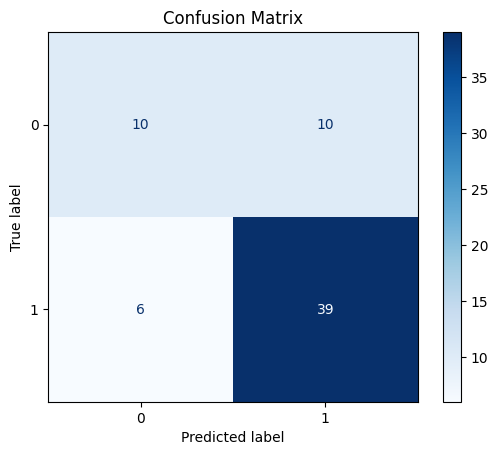


Evaluation: Random Forest (Tuned)
Accuracy:  0.9385
Precision: 0.9362
Recall:    0.9778
F1 Score:  0.9565


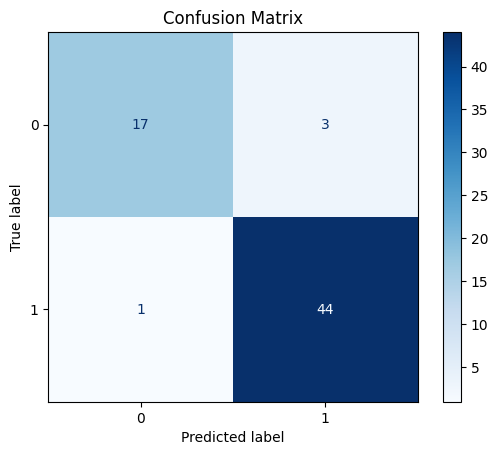


Evaluation: Support Vector Machine
Accuracy:  0.6923
Precision: 0.6923
Recall:    1.0000
F1 Score:  0.8182


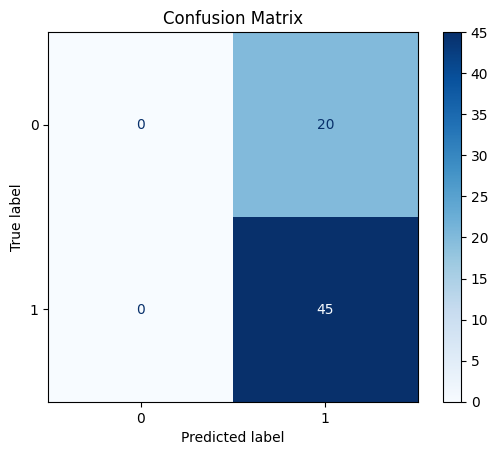

In [12]:
# Define a reusable function to evaluate classification models
def evaluate_model(model, X_valid, y_valid):
    # Generate predictions on validation data
    predictions = model.predict(X_valid)

    # Compute performance metrics
    accuracy = accuracy_score(y_valid, predictions)
    precision = precision_score(y_valid, predictions)
    recall = recall_score(y_valid, predictions)
    f1 = f1_score(y_valid, predictions)
    conf_matrix = confusion_matrix(y_valid, predictions)

    # Display evaluation results
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")

    # Plot the confusion matrix
    ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()

# Evaluate each trained model
print("Evaluation: Logistic Regression")
evaluate_model(logistic_model, X_valid, y_valid)

print("\nEvaluation: Random Forest (Tuned)")
evaluate_model(best_random_forest, X_valid, y_valid)

print("\nEvaluation: Support Vector Machine")
evaluate_model(svm_model, X_valid, y_valid)


Evaluation: Voting Classifier (Soft Voting)
Accuracy:  0.8462
Precision: 0.8302
Recall:    0.9778
F1 Score:  0.8980


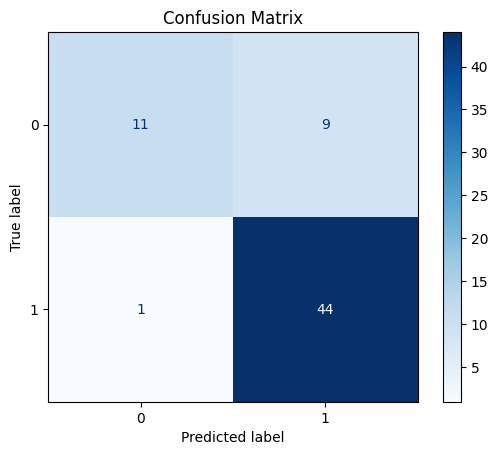

In [13]:
# Create a soft voting ensemble using Logistic Regression, Random Forest, and SVM
voting_classifier = VotingClassifier(
    estimators=[
        ('logistic', logistic_model),
        ('random_forest', best_random_forest),
        ('svm', svm_model)
    ],
    voting='soft'
)

# Train the ensemble model on the training data
voting_classifier.fit(X_train, y_train)

# Evaluate the performance of the Voting Classifier
print("Evaluation: Voting Classifier (Soft Voting)")
evaluate_model(voting_classifier, X_valid, y_valid)
